# Variational Auto Encoder

## Importing Libraries

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from torch.nn.functional import mse_loss
from skimage.metrics import structural_similarity as ssim

## Load Data

In [43]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Define VAE Model

In [44]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.mu = nn.Linear(256, latent_dim)
        self.log_var = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder(z)
        return x.view(-1, 1, 28, 28)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, log_var

## Loss Function

In [45]:
def vae_loss(reconstructed, original, mu, log_var):
    reconstruction_loss = nn.BCELoss(reduction='sum')(reconstructed, original)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

## Latent Space = 2

### Training

In [46]:
latent_dim = 2
vae = VAE(latent_dim).to('mps')
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to('mps')
        optimizer.zero_grad()
        reconstructed, mu, log_var = vae(images)
        loss = vae_loss(reconstructed, images, mu, log_var)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}")

Epoch 1, Loss: 174.37080930989583
Epoch 2, Loss: 156.1650975423177
Epoch 3, Loss: 150.7983317545573
Epoch 4, Loss: 148.08228334147137
Epoch 5, Loss: 146.31764041341145
Epoch 6, Loss: 145.22133855794272
Epoch 7, Loss: 144.2544568359375
Epoch 8, Loss: 143.22557029622396
Epoch 9, Loss: 142.59476490071614
Epoch 10, Loss: 142.1444331298828


### Evaluation

Mean Squared Error (MSE): 28.1637
Average Structural Similarity Index (SSIM): 0.5841


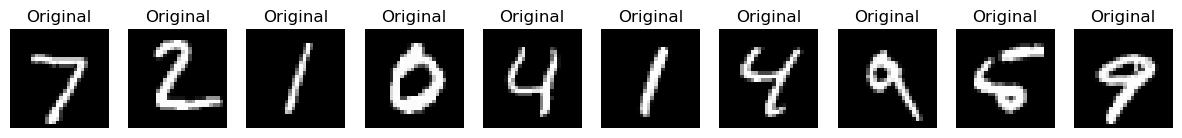

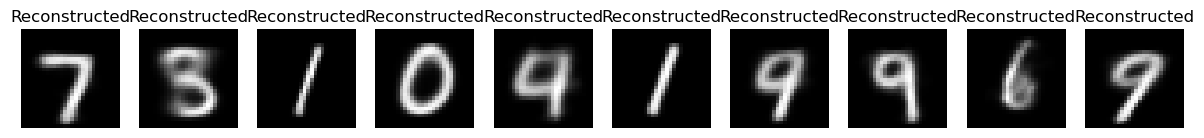

In [49]:
vae.eval()
test_images, _ = next(iter(test_loader))
test_images = test_images.to('mps')
ssim_scores = []
with torch.no_grad():
    reconstructed, _, _ = vae(test_images)

    total_mse = mse_loss(reconstructed, test_images, reduction='sum').item() / len(test_images)
    for i in range(len(test_images)):
        original = test_images[i].squeeze().cpu().numpy()
        recon = reconstructed[i].squeeze().cpu().numpy()
        score, _ = ssim(original, recon, full=True, data_range=1.0)
        ssim_scores.append(score)

average_ssim = np.mean(ssim_scores)
print(f"Mean Squared Error (MSE): {total_mse:.4f}")
print(f"Average Structural Similarity Index (SSIM): {average_ssim:.4f}")

fig, axes = plt.subplots(1, 10, figsize=(15, 4))
for i in range(10):
    axes[i].imshow(test_images[i].squeeze().cpu().numpy(), cmap='gray')
    axes[i].set_title("Original")
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(15, 4))
for i in range(10):
    axes[i].imshow(reconstructed[i].squeeze().cpu().numpy(), cmap='gray')
    axes[i].set_title("Reconstructed")
    axes[i].axis('off')
plt.show()

### Visualization

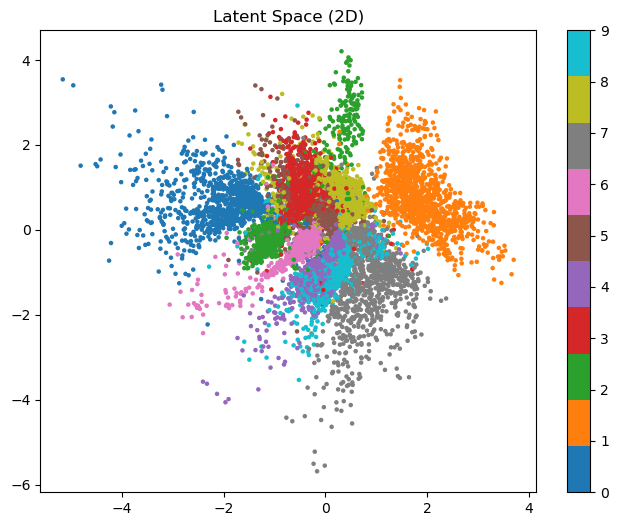

In [50]:
vae.eval()
latent_points = []
labels = []

with torch.no_grad():
    for images, lbls in test_loader:
        images = images.to('mps')
        _, mu, _ = vae(images)
        latent_points.append(mu.cpu().numpy())
        labels.append(lbls.numpy())

latent_points = np.concatenate(latent_points, axis=0)
labels = np.concatenate(labels, axis=0)

plt.figure(figsize=(8, 6))
plt.scatter(latent_points[:, 0], latent_points[:, 1], c=labels, cmap='tab10', s=5)
plt.colorbar()
plt.title("Latent Space (2D)")
plt.show()

## Latent Space = 4

### Training

In [51]:
latent_dim = 4
vae_4 = VAE(latent_dim).to('mps')
optimizer = optim.Adam(vae_4.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    vae_4.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to('mps')
        optimizer.zero_grad()
        reconstructed, mu, log_var = vae_4(images)
        loss = vae_loss(reconstructed, images, mu, log_var)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}")

Epoch 1, Loss: 159.379256258138
Epoch 2, Loss: 134.87345061848958
Epoch 3, Loss: 130.38028868815104
Epoch 4, Loss: 127.81704409993489
Epoch 5, Loss: 126.05971752115886
Epoch 6, Loss: 124.75025057779948
Epoch 7, Loss: 123.70181217854818
Epoch 8, Loss: 122.86918205159505
Epoch 9, Loss: 122.16782208251954
Epoch 10, Loss: 121.53521099853516


### Evaluation

Mean Squared Error (MSE): 20.1611
Average Structural Similarity Index (SSIM): 0.7029


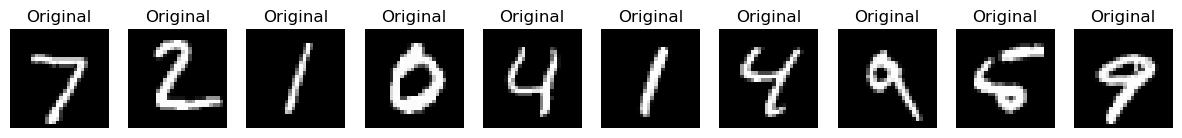

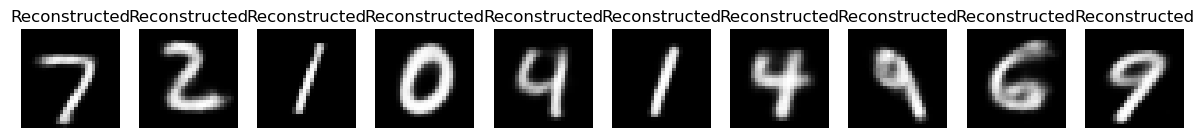

In [52]:
vae_4.eval()
test_images, _ = next(iter(test_loader))
test_images = test_images.to('mps')
ssim_scores = []
with torch.no_grad():
    reconstructed, _, _ = vae_4(test_images)

    total_mse = mse_loss(reconstructed, test_images, reduction='sum').item() / len(test_images)
    for i in range(len(test_images)):
        original = test_images[i].squeeze().cpu().numpy()
        recon = reconstructed[i].squeeze().cpu().numpy()
        score, _ = ssim(original, recon, full=True, data_range=1.0)
        ssim_scores.append(score)

average_ssim = np.mean(ssim_scores)
print(f"Mean Squared Error (MSE): {total_mse:.4f}")
print(f"Average Structural Similarity Index (SSIM): {average_ssim:.4f}")

fig, axes = plt.subplots(1, 10, figsize=(15, 4))
for i in range(10):
    axes[i].imshow(test_images[i].squeeze().cpu().numpy(), cmap='gray')
    axes[i].set_title("Original")
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(15, 4))
for i in range(10):
    axes[i].imshow(reconstructed[i].squeeze().cpu().numpy(), cmap='gray')
    axes[i].set_title("Reconstructed")
    axes[i].axis('off')
plt.show()

### Visualization

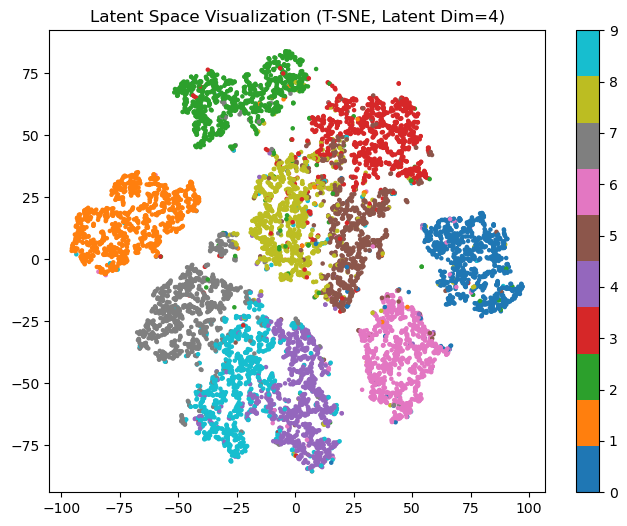

In [53]:
vae_4.eval()
latent_points = []
labels = []

with torch.no_grad():
    for images, lbls in test_loader:
        images = images.to('mps')
        _, mu, _ = vae_4(images)
        latent_points.append(mu.cpu().numpy())
        labels.append(lbls.numpy())

latent_points = np.concatenate(latent_points, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=42)
reduced_points = tsne.fit_transform(latent_points)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_points[:, 0], reduced_points[:, 1], c=labels, cmap='tab10', s=5)
plt.colorbar()
plt.title(f"Latent Space Visualization (T-SNE, Latent Dim={latent_dim})")
plt.show()

## Latent Space = 16

### Training

In [54]:
latent_dim = 16
vae_16 = VAE(latent_dim).to('mps')
optimizer = optim.Adam(vae_16.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    vae_16.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to('mps')
        optimizer.zero_grad()
        reconstructed, mu, log_var = vae_16(images)
        loss = vae_loss(reconstructed, images, mu, log_var)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}")

Epoch 1, Loss: 153.99385214029948
Epoch 2, Loss: 118.7145086751302
Epoch 3, Loss: 113.23917062174479
Epoch 4, Loss: 110.5205484741211
Epoch 5, Loss: 108.57266302083333
Epoch 6, Loss: 106.96910442708334
Epoch 7, Loss: 105.57771821695964
Epoch 8, Loss: 104.60970231933594
Epoch 9, Loss: 103.85689791666667
Epoch 10, Loss: 103.25261383463541


### Evaluation

Mean Squared Error (MSE): 11.8273
Average Structural Similarity Index (SSIM): 0.8144


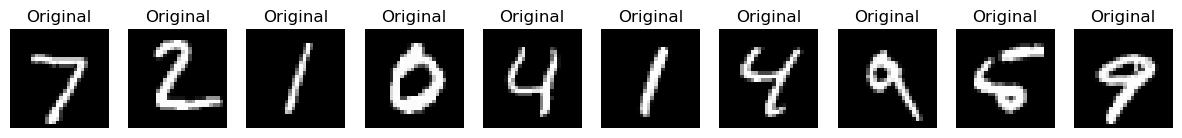

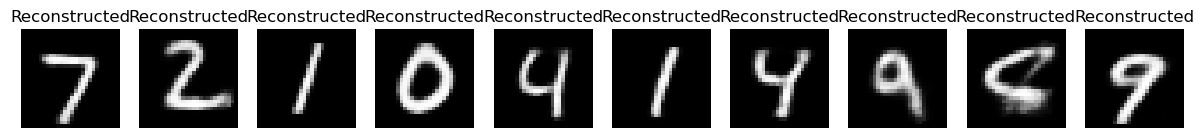

In [55]:
vae_16.eval()
test_images, _ = next(iter(test_loader))
test_images = test_images.to('mps')
ssim_scores = []
with torch.no_grad():
    reconstructed, _, _ = vae_16(test_images)

    total_mse = mse_loss(reconstructed, test_images, reduction='sum').item() / len(test_images)
    for i in range(len(test_images)):
        original = test_images[i].squeeze().cpu().numpy()
        recon = reconstructed[i].squeeze().cpu().numpy()
        score, _ = ssim(original, recon, full=True, data_range=1.0)
        ssim_scores.append(score)

average_ssim = np.mean(ssim_scores)
print(f"Mean Squared Error (MSE): {total_mse:.4f}")
print(f"Average Structural Similarity Index (SSIM): {average_ssim:.4f}")

fig, axes = plt.subplots(1, 10, figsize=(15, 4))
for i in range(10):
    axes[i].imshow(test_images[i].squeeze().cpu().numpy(), cmap='gray')
    axes[i].set_title("Original")
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(15, 4))
for i in range(10):
    axes[i].imshow(reconstructed[i].squeeze().cpu().numpy(), cmap='gray')
    axes[i].set_title("Reconstructed")
    axes[i].axis('off')
plt.show()

### Visualization

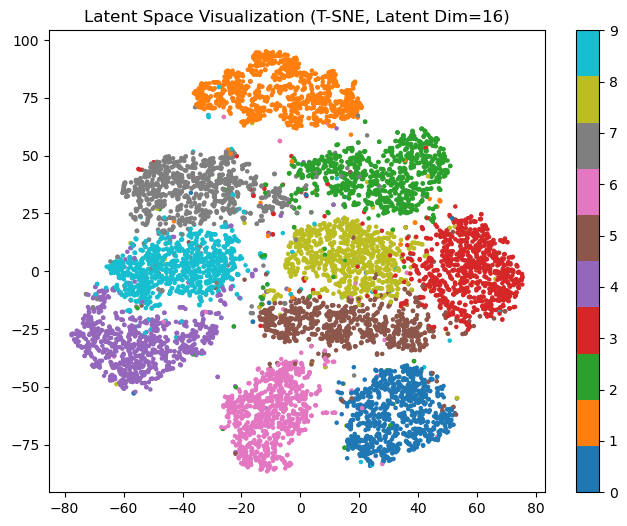

In [56]:
vae_16.eval()
latent_points = []
labels = []

with torch.no_grad():
    for images, lbls in test_loader:
        images = images.to('mps')
        _, mu, _ = vae_16(images)
        latent_points.append(mu.cpu().numpy())
        labels.append(lbls.numpy())

latent_points = np.concatenate(latent_points, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=42)
reduced_points = tsne.fit_transform(latent_points)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_points[:, 0], reduced_points[:, 1], c=labels, cmap='tab10', s=5)
plt.colorbar()
plt.title(f"Latent Space Visualization (T-SNE, Latent Dim={latent_dim})")
plt.show()